In [1]:
import pathlib
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Define and create paths

In [3]:
# Input paths
filename3 = "Plate_3_sc_norm_fs.parquet"
filename3p = "Plate_3_prime_sc_norm_fs.parquet"
plate_path = pathlib.Path(
    f"{root_dir}/nf1_painting_repo/3.processing_features/data/feature_selected_data"
)
model_all_data_path = f"{root_dir}/1.train_models/log_reg_plates_cp_fs_data/plates_3_3p"

path3 = plate_path / filename3
path3p = plate_path / filename3p

model_data_path = pathlib.Path(f"{model_all_data_path}/model_data")
model_path = pathlib.Path(f"{model_all_data_path}/trained_models")

# Output path
fig_path = pathlib.Path("precison_recall_curves")
fig_path.mkdir(parents=True, exist_ok=True)

## Load the model and plate data

In [4]:
# Load models
logreg_model_shuf = load(model_path / "log_reg_shuf_cp_fs_data_plate_3_3P.joblib")
logreg_model = load(model_path / "log_reg_cp_fs_data_plate_3_3p.joblib")

# Load label encoder
le = load(model_data_path / "label_encoder_log_reg_cp_fs_data_plate_3_3p.joblib")

# Load split data indices as dataframe
splitdf = pd.read_csv(model_data_path / "data_split_indices_log_reg_cp_fs_data_plate_3_3p.tsv", sep="\t", index_col=0)

# Load feature name data
feat_names = load(model_data_path / "feature_names_log_reg_cp_fs_data_plate_3_3p.joblib")

# Load plate data
plate3df = pd.read_parquet(path3)
plate3pdf = pd.read_parquet(path3p)

In [5]:
# Define gene column name
gene_column = "Metadata_genotype"

# Preprocess Data

## Use only common columns

In [6]:
# Set plate column:
plate3df["Metadata_plate"] = "3"
plate3pdf["Metadata_plate"] = "3p"

common_columns = plate3df.columns.intersection(plate3pdf.columns).to_list()
plate3df = plate3df.loc[:, common_columns]
plate3pdf = plate3pdf.loc[:, common_columns]

# Combine the plate dataframes:
platedf = pd.concat([plate3df, plate3pdf], axis="rows")

# Process data

In [7]:
# Use only WT and Null Genotypes
platedf = platedf.loc[platedf[gene_column] != "HET"]

## Merge the split data with the plate data

In [8]:
platedf = pd.merge(platedf, splitdf, left_index=True, right_index=True)

## Specify the feature column names

In [9]:
featdf = platedf[feat_names]

## Calculate Precision-Recall Curves

In [10]:
data_split = defaultdict(list)
split_column = "Metadata_split_name"

for model, data_type in list(product((logreg_model, logreg_model_shuf), ("train", "test"))):

    # Only use the shuffled training feature for calculating the shuffled model
    # unshuffled test data is used to evaluate the shuffled model
    if (model == logreg_model_shuf):
        shuffled = "shuffled"
        if (data_type == "train"):
            X_split_name = f"X_{data_type}_shuf"
        else:
            X_split_name = "X_test"
    else:
        shuffled = "not_shuffled"
        X_split_name = f"X_{data_type}"

    # Split the data based on the comparison being made
    Xdf = featdf.loc[platedf[split_column] == X_split_name]
    ydf = platedf.loc[platedf[split_column] == f"y_{data_type}"]["Metadata_genotype"]
    ydf = ydf.reindex(Xdf.index)

    # Encode the genotype labels
    y_val = le.transform(ydf)

    # Predict probabilites from the X data
    probas_pred = model.predict_proba(Xdf)

    # Calculate the precision, recall data
    precision, recall, proba_thresh = precision_recall_curve(y_val, probas_pred[:, -1])
    proba_thresh = np.append(proba_thresh, np.nan)

    # Calculate the suffled data
    metric_len = precision.shape[0]

    data_split["precision"].extend(precision.tolist())
    data_split["recall"].extend(recall.tolist())
    data_split["probability_threshold"].extend(proba_thresh.tolist())
    data_split["model_type"].extend([shuffled] * metric_len)
    data_split["split_type"].extend([data_type] * metric_len)

# Convert dictionary of lists to a dataframe
data_splitdf = pd.DataFrame(data_split)

# Plot precision-recall curves

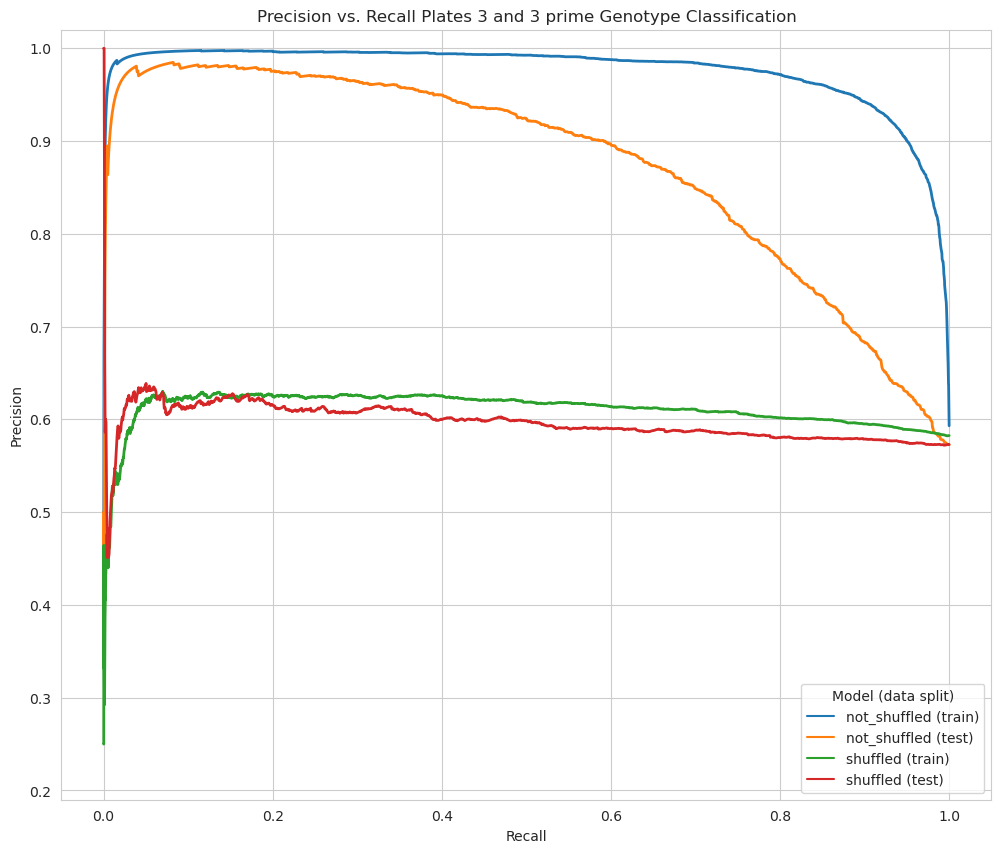

In [11]:
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

data_splitdf["plot_group"] = data_splitdf["model_type"] + " (" + data_splitdf["split_type"] + ")"

sns.lineplot(data=data_splitdf, x="recall", y="precision", hue="plot_group", errorbar=None, linewidth=2)

plt.legend(loc="lower right", title="Model (data split)")
plt.ylim(bottom=0.19, top=1.02)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall Plates 3 and 3 prime Genotype Classification")
plt.savefig(f"{fig_path}/precision_recall_plate_3_3p.png")